In [56]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from imutils import contours
from PIL.Image import Resampling
from PIL import Image
import PIL
from secrets import randbelow

In [267]:
def show(img, size=75):
    plt.figure(figsize=(size, size))

    if len(img.shape) == 2:  # if grayscale, set cmap
        plt.imshow(img, cmap="gray", vmin=0, vmax=255)
    else:  # if 3 channels, change from BGR to RGB
        plt.imshow(img[..., ::-1])

    plt.show()


def get_first_frame(videofile):
    vidcap = cv2.VideoCapture(videofile)
    success, image = vidcap.read()
    if success:
        # save frame as JPEG file
        cv2.imwrite("book_video_first_frame.jpg", image)


def get_keypoints(img):
    sift = cv2.SIFT_create()
    kp, des = sift.detectAndCompute(img, None)
    # img_keypoints = cv2.drawKeypoints(img, kp, img)
    return kp, des


def get_correspondences(img1, img2):
    kp1, des1 = get_keypoints(img1)
    kp2, des2 = get_keypoints(img2)

    # BFMatcher with default params
    bf = cv2.BFMatcher()

    # des1 = queryDescriptor, des2 = trainDescriptor
    matches = bf.knnMatch(des1, des2, k=2)

    # Apply ratio test
    good = []
    final_matches = []
    for m, n in matches:
        # Tune this ratio to control number of matches
        if m.distance < 0.23 * n.distance:
            good.append([m])
            final_matches.append([kp1[m.queryIdx].pt, kp2[m.trainIdx].pt])

    # cv.drawMatchesKnn expects list of lists as matches.
    # img3 = cv2.drawMatchesKnn(img1, kp1, img2, kp2, good,
    #                           None, flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
    # show(img3)
    print(f"found {len(good)} matches")

    return final_matches, img3


def construct_homography_matrix(matches):
    A = []
    for match in matches:
        xi = match[0][0]
        yi = match[0][1]

        xj = match[1][0]
        yj = match[1][1]

        A.append([xi, yi, 1, 0, 0, 0, -1 * xj * xi, -1 * xj * yi, -1 * xj])
        A.append([0, 0, 0, xi, yi, 1, -1 * yj * xi, -1 * yj * yi, -1 * yj])

    # print(A)

    u, s, vh = np.linalg.svd(A, full_matrices=True)
    h = vh[-1]
    return np.array(h).reshape((3, 3))


def aspect_ratio(cnt, img):
    rect = cv2.minAreaRect(cnt)
    # box = cv2.boxPoints(rect)
    # box = np.int0(box)
    # cv2.drawContours(img,[box],0,(0,0,255),2)
    # show(img, 10)
    
    center, shape, theta = rect
    h, w = shape
    ratio = float(w)/h

    # due to floating point errors, the dims are smaller than they should be
    return ratio, int(w*1.2), int(h*1.2)


def get_largest_contour(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edge = cv2.Canny(gray, 60, 180)
    blur = cv2.blur(edge, (9,9))
    contours, _ = cv2.findContours(blur, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
  
    biggestContour = max(contours, key = cv2.contourArea)
    epsilon = 0.051 * cv2.arcLength(biggestContour, True)
    approximation = cv2.approxPolyDP(biggestContour, epsilon, True)
    cv2.drawContours(image, [approximation], 0, (randbelow(256),randbelow(256),randbelow(256)), 2)
    # show(image, 10)

    mask = np.zeros(image.shape, np.uint8)
    cv2.drawContours(mask, [approximation], 0, (255,255,255), -1)
    # show(mask,10)
    return approximation, mask





def adjust_aspect_ratio(img, ratio):
    height = img.shape[0]
    total_width = img.shape[1]
    new_width = int(ratio * height)
    start_column = int((total_width - new_width)/2)
    resized_image = img[:, start_column:start_column+new_width]
    return resized_image



    




found 34 matches


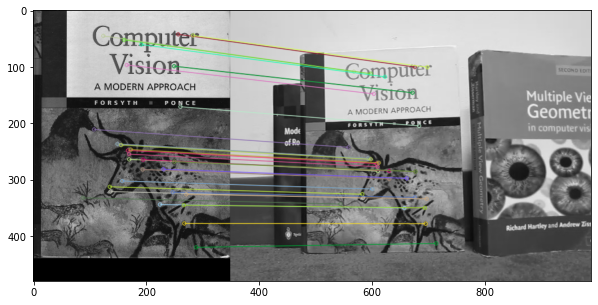

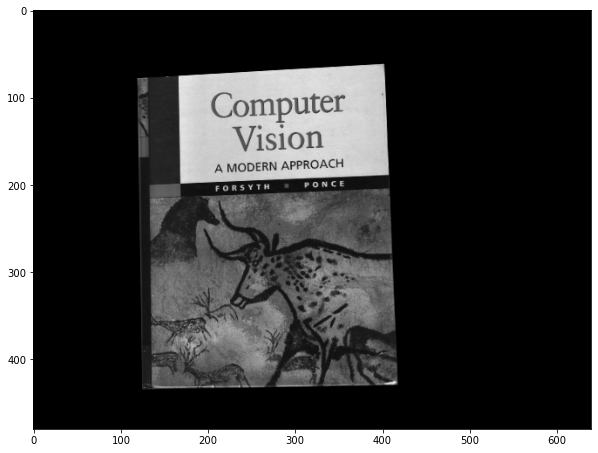

True

In [7]:
get_first_frame('book.mov')
book_cover = cv2.imread('cv_cover.jpg')
book_video_first_frame = cv2.imread('book_video_first_frame.jpg')

book_cover = cv2.cvtColor(book_cover, cv2.COLOR_BGR2GRAY)
book_video_first_frame = cv2.cvtColor(book_video_first_frame, cv2.COLOR_BGR2GRAY)

final_matches, img3 = get_correspondences(book_cover, book_video_first_frame)
show(img3, 10)

# This method of showing the image crashes the notbeook for me
# cv2.imshow('SIFT', img3)
# cv2.waitKey(0)

H = construct_homography_matrix(final_matches) # The homography matrix
# # print(H)

img1_out = cv2.warpPerspective(book_cover, H, (book_video_first_frame.shape[1], book_video_first_frame.shape[0]))
show(img1_out, 10)
# cv2.imshow('Warp Perspective', img1_out)
# # cv2.waitKey(0)


cartoon_video_first_frame = cv2.imread('cartoon_video_first_frame.jpg')

img2_out = cv2.warpPerspective(cartoon_video_first_frame, H, (book_video_first_frame.shape[1], book_video_first_frame.shape[0]))
# cv2.imshow('Warp Perspective', img2_out)
# cv2.waitKey()


cv2.imwrite("book_video_first_frame_wrapped.jpg", img1_out)
cv2.imwrite("cartoon_video_first_frame_wrapped.jpg", img2_out)

In [268]:
# Constants
book_video_path = 'book.mov'
movie_video_path = 'ar_source.mov'

# Read book cover image, grayscale
book_cover = cv2.imread('cv_cover.jpg')
book_cover_gray = cv2.cvtColor(book_cover, cv2.COLOR_BGR2GRAY)


book_video_cap = cv2.VideoCapture(book_video_path)
movie_video_cap = cv2.VideoCapture(movie_video_path)
output_video_writer = cv2.VideoWriter('output.avi', cv2.VideoWriter_fourcc(*'DIVX'), 15, (640, 480))
i = 0
while True:
  success, book_video_frame = book_video_cap.read()
  if success == False:
    break

  success, movie_video_frame = movie_video_cap.read()
  if success == False:
    break

  # Crop black bars
  movie_height = movie_video_frame.shape[0]
  crop = 45
  movie_video_frame = movie_video_frame[crop:movie_height-crop, :]

  # book_video_frame = cv2.cvtColor(book_video_frame, cv2.COLOR_BGR2GRAY)
  # movie_video_frame = cv2.cvtColor(movie_video_frame, cv2.COLOR_BGR2GRAY)



  # Get matches between book_cover and book in the video
  final_matches, img3 = get_correspondences(book_cover.copy(), book_video_frame)
  H = construct_homography_matrix(final_matches)

  # To find the aspect ratio of the book in the frame, we warp the cover to the frame, and compute the bounding box
  warped_book_cover = cv2.warpPerspective(book_cover, H, (book_video_frame.shape[1], book_video_frame.shape[0]))
  contour, mask = get_largest_contour(warped_book_cover)
  ratio, w, h = aspect_ratio(contour, warped_book_cover)
  # print(f"Aspect ratio (w/h): {ratio}, w {w}, h {h}")
  
  # Get the correct aspect ratio slice
  cropped_movie_frame = adjust_aspect_ratio(movie_video_frame, ratio)

  # Resize while maintaing the aspect ratio
  cropped_movie_frame = cv2.resize(
      cropped_movie_frame, (w,h), interpolation=cv2.INTER_AREA)

  cropped_warped_movie_frame = cv2.warpPerspective(cropped_movie_frame, H, (book_video_frame.shape[1], book_video_frame.shape[0]))
  # show(cropped_warped_movie_frame, 10)


  book_frame_copy = book_video_frame.copy()

  book_frame_copy[np.where(mask == 255)
                  ] = cropped_warped_movie_frame[np.where(mask == 255)]
  # show(book_frame_copy, 10)
  output_video_writer.write(book_frame_copy)
  i+=1
  print(f"{i} / 511")
  

output_video_writer.release()



found 29 matches
1 / 511
found 40 matches
2 / 511
found 43 matches
3 / 511
found 41 matches
4 / 511
found 47 matches
5 / 511
found 42 matches
6 / 511
found 39 matches
7 / 511
found 43 matches
8 / 511
found 45 matches
9 / 511
found 40 matches
10 / 511
found 41 matches
11 / 511
found 41 matches
12 / 511
found 49 matches
13 / 511
found 36 matches
14 / 511
found 37 matches
15 / 511
found 43 matches
16 / 511
found 40 matches
17 / 511
found 37 matches
18 / 511
found 39 matches
19 / 511
found 36 matches
20 / 511
found 47 matches
21 / 511
found 43 matches
22 / 511
found 45 matches
23 / 511
found 37 matches
24 / 511
found 36 matches
25 / 511
found 43 matches
26 / 511
found 43 matches
27 / 511
found 44 matches
28 / 511
found 41 matches
29 / 511
found 35 matches
30 / 511
found 51 matches
31 / 511
found 39 matches
32 / 511
found 37 matches
33 / 511
found 41 matches
34 / 511
found 41 matches
35 / 511
found 42 matches
36 / 511
found 43 matches
37 / 511
found 40 matches
38 / 511
found 41 matches
39 /

# To adjust the aspect ratio

In [8]:
book_video_path = 'book_video_first_frame_wrapped.jpg'
book_frame_contour = get_largest_contour(book_video_path)
book_frame_aspect_ratio = aspect_ratio(book_frame_contour)
print("Book Frame Aspect Ratio = " + str(book_frame_aspect_ratio))

cartoon_video_path = 'cartoon_video_first_frame_wrapped.jpg'
cartoon_frame_contour = get_largest_contour(cartoon_video_path)
cartoon_frame_aspect_ratio = aspect_ratio(cartoon_frame_contour)
print("Cartoon Frame Aspect Ratio = " + str(cartoon_frame_aspect_ratio))


aspect_ratio_adjusted_image = adjust_aspect_ratio('cartoon_video_first_frame_wrapped.jpg', book_frame_aspect_ratio) # Making the cartoon video frame have the same aspect ratio of the book video frame
show(aspect_ratio_adjusted_image)


width of : book_video_first_frame_wrapped.jpg object = 274
Book Frame Aspect Ratio = 1.37
width of : cartoon_video_first_frame_wrapped.jpg object = 520
Cartoon Frame Aspect Ratio = 2.1052631578947367


C:\Users\Abdallah\AppData\Local\Temp\ipykernel_18772\2289786477.py:105: DeprecationWarning: BICUBIC is deprecated and will be removed in Pillow 10 (2023-07-01). Use Resampling.BICUBIC instead.
  resized_image = img.resize((wsize, hsize), PIL.Image.BICUBIC)


AttributeError: shape

<Figure size 5400x5400 with 0 Axes>

# For Masking

In [19]:
book_frame = cv2.imread('book_video_first_frame_wrapped.JPG')
cartoon_frame = cv2.imread('cartoon_video_first_frame_wrapped_resized.JPG')

cartoon = cv2.resize(cartoon_frame, (book_frame.shape[1], book_frame.shape[0]))


ret, cartoon_mask = cv2.threshold(cartoon[:,:,0], 0, 255, cv2.THRESH_BINARY|cv2.THRESH_OTSU)
cv2.imshow('cartoon_mask', cartoon_mask)

book_frame_copy = book_frame.copy()

book_frame_copy[np.where(cartoon_mask == 255)] = cartoon[np.where(cartoon_mask == 255)]

cv2.imshow('book_result.JPG', book_frame_copy)
cv2.waitKey()
cv2.destroyAllWindows()

new_aspect_ratio = 0.5
out = cartoon.resize([int(new_aspect_ratio * s) for s in cartoon.size])
cv2.imshow('cartoon resized', out)
cv2.waitKey()